# Synthetic dataset

In this file we are going to generate synthetic noisy data. The result of this section will be used for training a TD3 model to eliminate noise and reconstruct phylogenetic tree.

It is mentiond that the generated data contains both SNV matrix and CNV profile per sample beside ground-truth tree.

____

## Activating virtual environment

In [1]:
!source ../venv/bin/activate

In [2]:
# !apt update
# !apt --assume-yes install python-pydot python-pydot-ng graphviz

In [3]:
!pip install --upgrade pip

In [4]:
!pip install -r ../requirements.txt

## Import required packages

In [5]:
import scipy as sp
import numpy as np
from scipy import stats
import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_tree
from matplotlib import pyplot as plt
import matplotlib as mpl
import random
import matplotlib.image as mpimg
import graphviz
import imageio, json
from IPython.display import Image
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.patches as mpatches

## Configuration

In [6]:
font = {
    'weight' : 'normal',
    'size'   : 13,
}
mpl.rc('font', **font)

## Define functions

In [7]:
def plot_mat(M, row='', col='', title='', save_name=None):
    rows, cols = M.shape[:2]
    plt.imshow(M, cmap='GnBu', interpolation="nearest")
    plt.yticks(range(E.shape[0]), ['%s %d'%(row,i) for i in range(rows)])
    plt.xticks(range(E.shape[1]), ['%s %d'%(col,i) for i in range(cols)])
    plt.xticks(rotation=60)
    plt.xlabel('{}-{} Matrix'.format(row.capitalize(), col.capitalize()))
    plt.title(title)
    if save_name:
        plt.savefig(save_name)
    plt.imshow()
    plt.close()
    
    
def plot_tree(tree, save_name=None):
    pass

## Define classes

### Define the Tree class

In [29]:
class Tree(object):
    def __init__(self, T, E, E_l, CP, lossed_genes, **params):
        self.__T = T
        self.__E = E
        self.__E_l = E_l
        self.__CP = CP
        self.__N = E.shape[0]
        self.__M = E.shape[1]
        params['N'] = self.__N
        params['M'] = self.__M
        self.params = params
        self.lossed_genes = lossed_genes
        self.psi = params['psi']
        self.vartheta = params['vartheta']
        self.varrho = params['varrho']

        self.__plot_scale = 30./max(self.__M, self.__N)
        
        self.__set_params(params)
        self.generate_data(**params)

        
    def generate_data(self, **params):
        self.__new_param = self.__params
        for k,v in params.items():
            self.__new_param[k]=v
        
        if not json.dumps(self.__params) == json.dumps(self.__new_param):
            print('Prev params:')
            print('\t'.join(json.dumps(self.__params, indent=True).splitlines()))
            self.__set_params(self.__new_param)
            print('New params:')
            print('\t'.join(json.dumps(params, indent=True).splitlines()))

        ## ========================================================
        ## ~~~~~~~~~~~~~~~~~~~~~~~~ E to D ~~~~~~~~~~~~~~~~~~~~~~~~
        ## ========================================================
        D = self.__E.copy()
        nz_idxs = np.nonzero(self.__E)
        z_idxs  = np.nonzero(self.__E-1)
        z_rnds  = np.random.rand(len( z_idxs[0]))
        nz_rnds = np.random.rand(len(nz_idxs[0]))
        z_rnds  = [1 if i < self.__alpha  else 0 for i in  z_rnds]
        nz_rnds = [0 if i < self.__beta   else 1 for i in nz_rnds]
        D[nz_idxs] = nz_rnds
        D[ z_idxs] =  z_rnds
        self.__D = D
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~~~~~~~ E_l to D_l ~~~~~~~~~~~~~~~~~~~~~~
        ## ========================================================
#         D_l = self.__E_l.copy()
        D_l = np.where(self.__E_l < 1, 0, 1)
        nz_idxs = np.nonzero(self.__E_l)
        z_idxs  = np.nonzero(self.__E_l-1)
        z_rnds  = np.random.rand(len( z_idxs[0]))
        nz_rnds = np.random.rand(len(nz_idxs[0]))
        z_rnds  = [1 if i < self.__alpha  else 0 for i in  z_rnds]
        nz_rnds = [0 if i < self.__beta   else 1 for i in nz_rnds]
        D_l[nz_idxs] = nz_rnds
        D_l[ z_idxs] =  z_rnds
        self.__D_l = D_l
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~ add missing data Dm ~~~~~~~~~~~~~~~~~~~
        ## ========================================================
        Dm = self.__D.copy()
        idxs = np.nonzero(self.__D+1)
        rnds = np.random.rand(self.__N, self.__M)
        for n in range(self.__N):
            for m in range(self.__M):
                if rnds[n, m] < self.__MR:
                    Dm[n, m] = 3
        self.__Dm = Dm
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~ add missing data Dlm ~~~~~~~~~~~~~~~~~~
        ## ========================================================
        Dlm = self.__D_l.copy()
        idxs = np.nonzero(self.__D_l+1)
        rnds = np.random.rand(self.__N, self.__M)
        for n in range(self.__N):
            for m in range(self.__M):
                if rnds[n, m] < self.__MR:
                    Dlm[n, m] = 3
        self.__Dlm = Dlm
        
        
    def __set_params(self, params):
        self.__alpha = params['alpha']
        self.__beta  = params['beta']
        self.__MR    = params['MR'] # missing rate
        
        self.__params = params
        self.__str_params  ='_'.join(['{}={}'.format(k,v) for k,v in params.items()])
        self.__latex_params='\ '.join(['{}={}'.format(k if len(k)<3 else '\%s'%k,v) for k,v in params.items()])
        
        
    def save_data(save_dir):
        if not save_dir[-1]=='/':
            save_dir += '/'
        p = 'Parameters: {}\n'.format(self.__str_params)
        np.savetxt('{}E.csv'.format(save_dir), E, fmt='%.0f', delimiter=',', header=p)
        np.savetxt('{}D.csv'.format(save_dir), D, fmt='%.0f', delimiter=',', header=p)
        np.savetxt('{}DmE.csv'.format(save_dir), D-E, fmt='%.0f', delimiter=',', header=p)
        np.savetxt('{}Dm.csv'.format(save_dir), Dm, fmt='%.0f', delimiter=',', header=p)
    
                       
    def get_E(self,):
        return self.__E
    
    def get_D(self,):
        return self.__D
                       
    def get_Dm(self,):
        return self.__Dm
    
    def get_T(self,):
        return self.__T
                       
    def get_params(self,):
        return self.__params
                       
    def get_alpha(self,):
        return self.__alpha
    
    def get_beta(self,):
        return self.__beta
    
    
    def save_tree(self, save_path):
        file_path = '{}Tree_{}.gpickle'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
        nx.write_gpickle(self.__T, file_path)
    
    
    def plot_tree_mut(self, save_path):
        mut_T = self.__T.copy()
#         mut_T.remove_nodes_from([i for i,n in enumerate(self.__T.nodes()) if 'cell' in str(n)])
        pdot = nx.drawing.nx_pydot.to_pydot(mut_T)
        file_path = '{}treeM_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
        pdot.write_png(file_path)
        display(Image(filename=file_path))
        
        
    def plot_tree_full(self, save_path, title=None):
        pdot = nx.drawing.nx_pydot.to_pydot(self.__T)
        for i, node in enumerate(pdot.get_nodes()):
            node_name = str(node)[:-1]
            if 'cell' in node_name:
                node.set_label('s%s'%node_name.split()[-1][:-1])
                node.set_shape('egg')
                node.set_fillcolor('#db8625')
                node.set_color('red')
        file_path = f'{save_path}treeF_{self.__str_params}.png' if save_path[-1] == '/' else save_path
        pdot.write_png(file_path)
        if title: print(title)
        display(Image(filename=file_path))
    
    
    def plot_E(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        plt.imshow(self.__E, cmap='GnBu', interpolation="nearest")
        plt.yticks(range(self.__E.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__E.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('Genes-Cells Matrix E (Error-less)')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}E_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()
            
    
    def plot_E_l(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        ## first you need to define your color map and value name as a dict
        t = 1 ## alpha value
        cmap = {0:[1,1,0.95,t], 1:[0.25,0.25,0.5,t], 0.5:[0.9,0.25,0.5,t]}
        labels = {0:'0', 1:'1', 0.5:'lost'}
        arrayShow = np.array([[cmap[i] for i in j] for j in self.__E_l])    
        ## create patches as legend
        patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
        plt.imshow(arrayShow, interpolation="nearest")
        plt.legend(handles=patches, loc=2, borderaxespad=-6)
        plt.yticks(range(self.__E.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__E.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('$E with lossed mutation$')
        plt.title(r'Parameters: ${}$'.format(
            "\ ".join([
                f"N={self.__N}", f"M={self.__M}", 
                f"\zeta={self.params['zeta']}", f"\gamma={self.params['gamma']}"
                f"\psi={self.psi}", f"\vartheta={self.vartheta}", f"\varrho={self.varrho}", 
            ])
        ))
        if save_path is not None:
            file_path = '{}El_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()
    
    
    def plot_D(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        plt.imshow(self.__D, cmap='GnBu', interpolation="nearest")
        plt.yticks(range(self.__D.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__D.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('Noisy Genes-Cells Matrix D (input Data)')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}D_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()


    def plot_D_l(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        plt.imshow(self.__D_l, cmap='GnBu', interpolation="nearest")
        plt.yticks(range(self.__D_l.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__D_l.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('Noisy Genes-Cells Matrix D_l (input Data)')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}Dl_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()

        
    def plot_DmE(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        ## first you need to define your color map and value name as a dict
        t = 1 ## alpha value
        cmap = {0:[1,1,0.95,t], 1:[0.5,0.5,0.8,t], -1:[0.8,0.5,0.5,t]}
        labels = {0:'true', 1:'false positive', -1:'false negetive'}
        arrayShow = np.array([[cmap[i] for i in j] for j in self.__D-self.__E])    
        ## create patches as legend
        patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
        plt.imshow(arrayShow, interpolation="nearest")
        plt.legend(handles=patches, loc=2, borderaxespad=-6)
        plt.yticks(range(self.__E.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__E.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('D-E')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}DmE_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()
            
    def plot_DlmEl(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        ## first you need to define your color map and value name as a dict
        t = 1 ## alpha value
        cmap = {0:[1,1,0.95,t], 1:[0.5,0.5,0.8,t], -1:[0.8,0.5,0.5,t]}
        labels = {0:'true', 1:'false positive', -1:'false negetive'}
        arrayShow = np.array([[cmap[i] for i in j] for j in self.__D_l-self.__E_l])    
        ## create patches as legend
        patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
        plt.imshow(arrayShow, interpolation="nearest")
        plt.legend(handles=patches, loc=2, borderaxespad=-6)
        plt.yticks(range(self.__E_l.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__E_l.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('Dl-El')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}DlmEl_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()
    
    
    def plot_Dm(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        ## first you need to define your color map and value name as a dict
        t = 1 ## alpha value
        cmap = {0:[1,1,0.95,t], 1:[0.2,0.2,0.4,t], 3:[0.8,0.5,0.5,t]}
        labels = {0:'0', 1:'1', 3:'missed'}
        arrayShow = np.array([[cmap[i] for i in j] for j in self.__Dm])    
        ## create patches as legend
        patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

        plt.imshow(arrayShow, interpolation="nearest")
        plt.legend(handles=patches, loc=2, borderaxespad=-6)
        plt.yticks(range(self.__D.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__D.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('Noisy Genes-Cells Matrix with Missed Data ($D_m$)')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}Dm_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()
            
    def plot_Dlm(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        ## first you need to define your color map and value name as a dict
        t = 1 ## alpha value
        cmap = {0:[1,1,0.95,t], 1:[0.2,0.2,0.4,t], 3:[0.8,0.5,0.5,t]}
        labels = {0:'0', 1:'1', 3:'missed'}
        arrayShow = np.array([[cmap[i] for i in j] for j in self.__Dlm])    
        ## create patches as legend
        patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

        plt.imshow(arrayShow, interpolation="nearest")
        plt.legend(handles=patches, loc=2, borderaxespad=-6)
        plt.yticks(range(self.__D_l.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__D_l.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('Noisy Genes-Cells Matrix with Missed Data ($Dl_m$)')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}Dlm_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()
    
    def plot_all_mat(self, figsize=None):
        figsize = figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale)
        plt.figure(figsize=figsize)
        plt.subplot(2, 2, 1)
        plt.title('E')
        self.plot_E(figsize=np.asarray(figsize)/2, nofig=True)
        plt.subplot(2, 2, 2)
        plt.title('D')
        self.plot_D(figsize=np.asarray(figsize)/2, nofig=True)
        plt.subplot(2, 2, 3)
        plt.title('D-E')
        self.plot_DmE(figsize=np.asarray(figsize)/2, nofig=True)
        plt.subplot(2, 2, 4)
        plt.title('Dm')
        self.plot_Dm(figsize=np.asarray(figsize)/2, nofig=True)
        plt.show()
        
        plt.figure(figsize=figsize)
        plt.subplot(2, 2, 1)
        plt.title('E_l')
        self.plot_E_l(figsize=np.asarray(figsize)/2, nofig=True)
        plt.subplot(2, 2, 2)
        plt.title('D_l')
        self.plot_D_l(figsize=np.asarray(figsize)/2, nofig=True)
        plt.subplot(2, 2, 3)
        plt.title('D_l-E_l')
        self.plot_DlmEl(figsize=np.asarray(figsize)/2, nofig=True)
        plt.subplot(2, 2, 4)
        plt.title('Dlm')
        self.plot_Dlm(figsize=np.asarray(figsize)/2, nofig=True)
        plt.show()

In [46]:
class TreeGenerator():
    '''
    Inputs: (M, N, ZETA, Gamma, alpha, beta, MR, save_images, save_trees, save_mats)
        --------------------------------------
        M       :   num of genes (mutations)
        --------------------------------------
        N       :   num of samples (cells)
        --------------------------------------
        ZETA    :   homogeness of tree
        --------------------------------------
        Gamma   :   merge genes
        --------------------------------------
        alpha   :   ~ P(D=1|E=0)
        --------------------------------------
        beta    :   ~ P(D=0|E=1)
        --------------------------------------
        MR      :   missing ratio
        --------------------------------------
        psi     :   Loss probablity of a mutation in T
        --------------------------------------
        vartheta:   A parameter related to distanse
        --------------------------------------
        varrho  :   Probablity of rejecting lossable genes respect to decreased copy number
        --------------------------------------
        

    Outputs: (E, D, Dm, T)
        ------------------------------------------------
        E       :   Mutation-cell matrix without errors
        ------------------------------------------------
        D       :   Mutation-cell matrix with errors
        ------------------------------------------------
        Dm      :   <D> with missed data
        ------------------------------------------------
        T       :   The generated tree
        ------------------------------------------------
    '''

    def __init__(self,
        M, N, 
        ZETA=1, Gamma=0.15, alpha=0.001,beta=0.08, MR=0.05,
        psi = 0.7, vartheta = 0.2, varrho = 0.2,
        cnp_length=5, cnp_init_min=2, cnp_init_max=5, cnp_end_max=8, cnp_end_min=0,
        save_dir=None):

        self.M=M
        self.N=max(M, N)
        self.ZETA=ZETA
        self.Gamma=Gamma
        self.alpha=alpha
        self.beta=beta
        self.MR=MR
        self.psi=psi
        self.vartheta=vartheta
        self.varrho=varrho
        self.cnp_length=cnp_length
        self.cnp_init_min=cnp_init_min
        self.cnp_init_max=cnp_init_max
        self.cnp_end_max=cnp_end_max
        self.cnp_end_min=cnp_end_min
        self.save_dir=save_dir


    def generate(self,):
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~ generate a random tree ~~~~~~~~~~~~~~~~
        ## ========================================================
        self.Tree = dict()
        self.cnt = 2
        xk = np.arange(self.M+1)
        name_k = [str(i) for i in xk]
        wk = np.ones(self.M+1, dtype=np.float128)
        while True:
            xk, wk, name_k, u, v = self.do_next(xk, wk, name_k)
            self.cnt+=1
            if len(xk) < 2:
                break
        T = nx.DiGraph(self.Tree)
        T_leaves = [x for x in T.nodes() if T.out_degree(x)==0 and T.in_degree(x)==1]
        T.remove_nodes_from(T_leaves)
        t = np.arange(self.M)
        np.random.shuffle(t)
        t = dict((i, j) for i,j in zip(T.nodes(), t))
        T = nx.relabel_nodes(T, t)
        raw_T = T.copy()
        root = [n for n,d in raw_T.in_degree() if d==0][0]
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~ merge some of mutations ~~~~~~~~~~~~~~~~
        ## ========================================================
        A = int(np.floor(self.Gamma*self.M))
        if A:
            for i in range(A):
                while True:
                    p, c = random.sample(T.edges(),1)[0]
                    if p != root: break
                for child in T.successors(c):
                    T.add_edge(p,child)        
                T.remove_node(c)
                T = nx.relabel_nodes(T, {p: '{} . {}'.format(p,c)})

        ## ========================================================
        ## ~~~~~~~~~~~~~~~~~ add cells to the tree ~~~~~~~~~~~~~~~~
        ## ========================================================
        Mutaions_T = T.copy()
        mutaion_nodes = Mutaions_T.nodes()
        cells = np.array(['cell %d'%i for i in range(self.N)])
        np.random.shuffle(cells)
        for n in mutaion_nodes:
            T.add_edge(n, cells[0])
            cells = cells[1:]
        for cell in cells:
            node = random.sample(mutaion_nodes, 1)[0]
            T.add_edge(node, cell)
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~~~~~~~ Tree to E ~~~~~~~~~~~~~~~~~~~~~~~
        ## ========================================================
        E = np.zeros([self.N, self.M])        
        E[int(root), :] = 1        
        for n in range(self.N):
            try:
                path = list(nx.all_simple_paths(T, root, 'cell %d'%n))[0]
            except:
                print('root:', root)
                pdot = nx.drawing.nx_pydot.to_pydot(T)
                pdot.write_png('problem_tree.png')
                exit()
            for g in path[:-1]:
                try:
                    E[n, int(g)] = 1
                except:
                    gs = g.split(' . ')
                    for g in gs:
                        E[n, int(g)] = 1

        ## ========================================================
        ## ~~~~~~~~~~~~ perform acceptable losses (CP) ~~~~~~~~~~~~
        ## ========================================================
#         '''
#         0. Prpare list of links named `all_L`
#         1. Choose a random link L_i:(M_u->M_v) from `all_L` if their contain at least one sample individualy.
#             In fact we choose two samples (S_u, S_v).
#         2. Choose a set of mutations in ancestors of `M_v` named M_xs.
#         3.  [a] Add an attribute to selected link L_i:(loss M_x).
#             [b] For each cell_i that contains M_v, triger M_x to 0.
#             [c] Write "L(S_u,_Sv): M_xs" in the CP_gt.txt file.
#             [d] Write "L(S_u,_Sv): M_xs,<some random Ms in [M in path (v->root)]-[M_xs]>" in the CP.txt file.
#         4. Remove L_i from `all_L`
#         5. If it is not enough go to step 1.
#         6. Repeat Y times above loop to achieve additional L(i,j). 
#             But in this case append them just to the CP.txt file.
#         '''

        gene_cnp_idx = np.random.randint(0, self.cnp_length, self.M)
        initial_cnp = np.random.randint(self.cnp_init_min, self.cnp_init_max, self.cnp_length)

        root = [n for n,d in T.in_degree() if d==0][0]
        cnp_dict = {
            'nodes': {
                str(root): initial_cnp
            },
            'cells': {}
        }
        lossable_genes_all = {}
        for node in nx.traversal.bfs_tree(T, root):
            if node == root: continue
            node_str = str(node)
            for parent in T.predecessors(node):
                break
            parent_cnp = cnp_dict['nodes'][str(parent)]
            if 'cell' in node_str:
                cnp_dict['cells'][node_str] = parent_cnp
            else:
                new_cnp, lossable_genes = self.__gen_new_cnp(parent_cnp, gene_cnp_idx)
                cnp_dict['nodes'][node_str] = new_cnp
                if lossable_genes and np.random.rand() > self.varrho:
                    valid_lossable_genes = []
                    dist = 0
                    for parent in nx.algorithms.shortest_path(T.to_undirected(), node, root):
                        if parent == node: continue
                        dist += 1
                        if '.' in str(parent):
                            parents = [int(p) for p in parent.split(' . ')]
                            for parent in parents:
                                if parent in lossable_genes:
                                    valid_lossable_genes.append((parent, dist))
                        else:
                            if parent in lossable_genes:
                                valid_lossable_genes.append((parent, dist))

                    loss_point = node_str
                    for valid_lossable_gen, dist in valid_lossable_genes:
                        if str(valid_lossable_gen) in lossable_genes_all.keys():
                            lossable_genes_all[str(valid_lossable_gen)].append({'loss_point': loss_point, 'distance': dist})
                        else:
                            lossable_genes_all[str(valid_lossable_gen)] = [{'loss_point': loss_point, 'distance': dist}]

        self.lossed_genes = []
        for lossable_gen, values in lossable_genes_all.items():
            if np.random.rand() > self.psi:
                distances = [v['distance'] for v in values]
                chooseable_points = [v['loss_point'] for v in values]
                choosed_idx = np.random.randint(0, len(distances))
                choosed_distance = distances[choosed_idx]
                choosed_loss_point = chooseable_points[choosed_idx]

                self.lossed_genes.append({
                    "gene": str(lossable_gen),
                    "loss_point": choosed_loss_point
                })

        self.CP = np.zeros([self.N, self.cnp_length])
        for cell, cnp in cnp_dict['cells'].items():
            cell_idx = int(cell.split(' ')[-1])
            for j, cn in enumerate(cnp):
                self.CP[cell_idx, j] = cn

        ## ========================================================
        ## ~~~~~~~~~~~~~~ E_l: E with lossed genes ~~~~~~~~~~~~~~~~
        ## ========================================================
        E_l = E.copy()
        
        for lossed_gene in self.lossed_genes:
            gene = lossed_gene["gene"]
            loss_point = lossed_gene["loss_point"]
            
            try:
                sT = dfs_tree(T, int(loss_point))
            except:
                sT = dfs_tree(T, loss_point)
            cells = [n for n in sT.nodes() if sT.out_degree(n)==0 and sT.in_degree(n)==1]
            for cell in cells:
                cell_idx = int(cell.split(" ")[-1])
                E_l[cell_idx, int(gene)] = 0
#                 E[cell_idx, int(gene)] = 0.5
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~ return generated data ~~~~~~~~~~~~~~~~~
        ## ========================================================
        tree_obj = Tree(
            T=T.copy(), E=E, E_l=E_l, CP=self.CP,
            zeta = self.ZETA,
            gamma = self.Gamma,
            alpha = self.alpha,
            beta = self.beta,
            MR = self.MR,
            lossed_genes = self.lossed_genes,
            psi = self.psi,
            vartheta = self.vartheta,
            varrho = self.varrho,
        )
        return tree_obj
        return (E.astype(int), D.astype(int), Dm.astype(int), raw_T)


    def do_next(self, xk, wk, name_k):
        u, v = self.__weighted_drand(xk, wk, size=2)
        idx_u = np.where(xk==u)[0]
        idx_v = np.where(xk==v)[0]
        w_u = wk[idx_u]
        w_v = wk[idx_v]
        w_uv = (w_u+w_v)/(self.ZETA**0.25)
        nu = name_k[int(idx_u)]
        nv = name_k[int(idx_v)]
        nuv = '{}.{}'.format(nu, nv)
        self.Tree[nuv] = [nu, nv]
        xk = np.delete(xk, [idx_u, idx_v])
        name_k = np.delete(name_k, [idx_u, idx_v])
        wk = np.delete(wk, [idx_u, idx_v])
        xk = np.append(xk, self.M+self.cnt)
        name_k = np.append(name_k, nuv)
        wk = np.append(wk, w_uv)
        return (xk, wk, name_k, u, v)
    
    @staticmethod
    def __rand_pmf(xk, pk, size=1):
        custm = stats.rv_discrete(name='custm', values=(xk, pk))
        cnt = 0
        while True:
            rs = custm.rvs(size = size)
            if len(set(rs)) == len(rs):
                break
            cnt+=1
        return rs

    def __weighted_drand(self, xk, wk, size=1):
        pk = wk/np.sum(wk, dtype=np.float128)
        return self.__rand_pmf(xk, pk, size)
    
    def __gen_new_cnp(self, cnp, gene_cnp_idx):
            new_cnp = []
            lossable_genes = []
            for i, cn in enumerate(cnp):
                rnd = np.random.rand()
                if rnd < 0.1:
                    new_cnp.append(max(self.cnp_end_min, cn-1))
                    lossable_genes = np.where(gene_cnp_idx == i)[0].tolist()
                elif rnd > 0.85:
                    new_cnp.append(min(self.cnp_end_max, cn+1))
                else:
                    new_cnp.append(cn)
            return new_cnp, lossable_genes

## Test generator

In [31]:
N, M = 30, 20

generator = TreeGenerator(
    M,
    N,
    ZETA=1,
    Gamma=0.15,
    alpha=0.01,
    beta=0.1,
    MR=0.02,
    save_dir=False,
)

In [32]:
tree_obj = generator.generate()

/var/folders/b0/rzwm_fmx68v24nxtr096b_dw0000gn/T/ipykernel_9952/2304423652.py:95: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  p, c = random.sample(T.edges(),1)[0]
/var/folders/b0/rzwm_fmx68v24nxtr096b_dw0000gn/T/ipykernel_9952/2304423652.py:113: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  node = random.sample(mutaion_nodes, 1)[0]


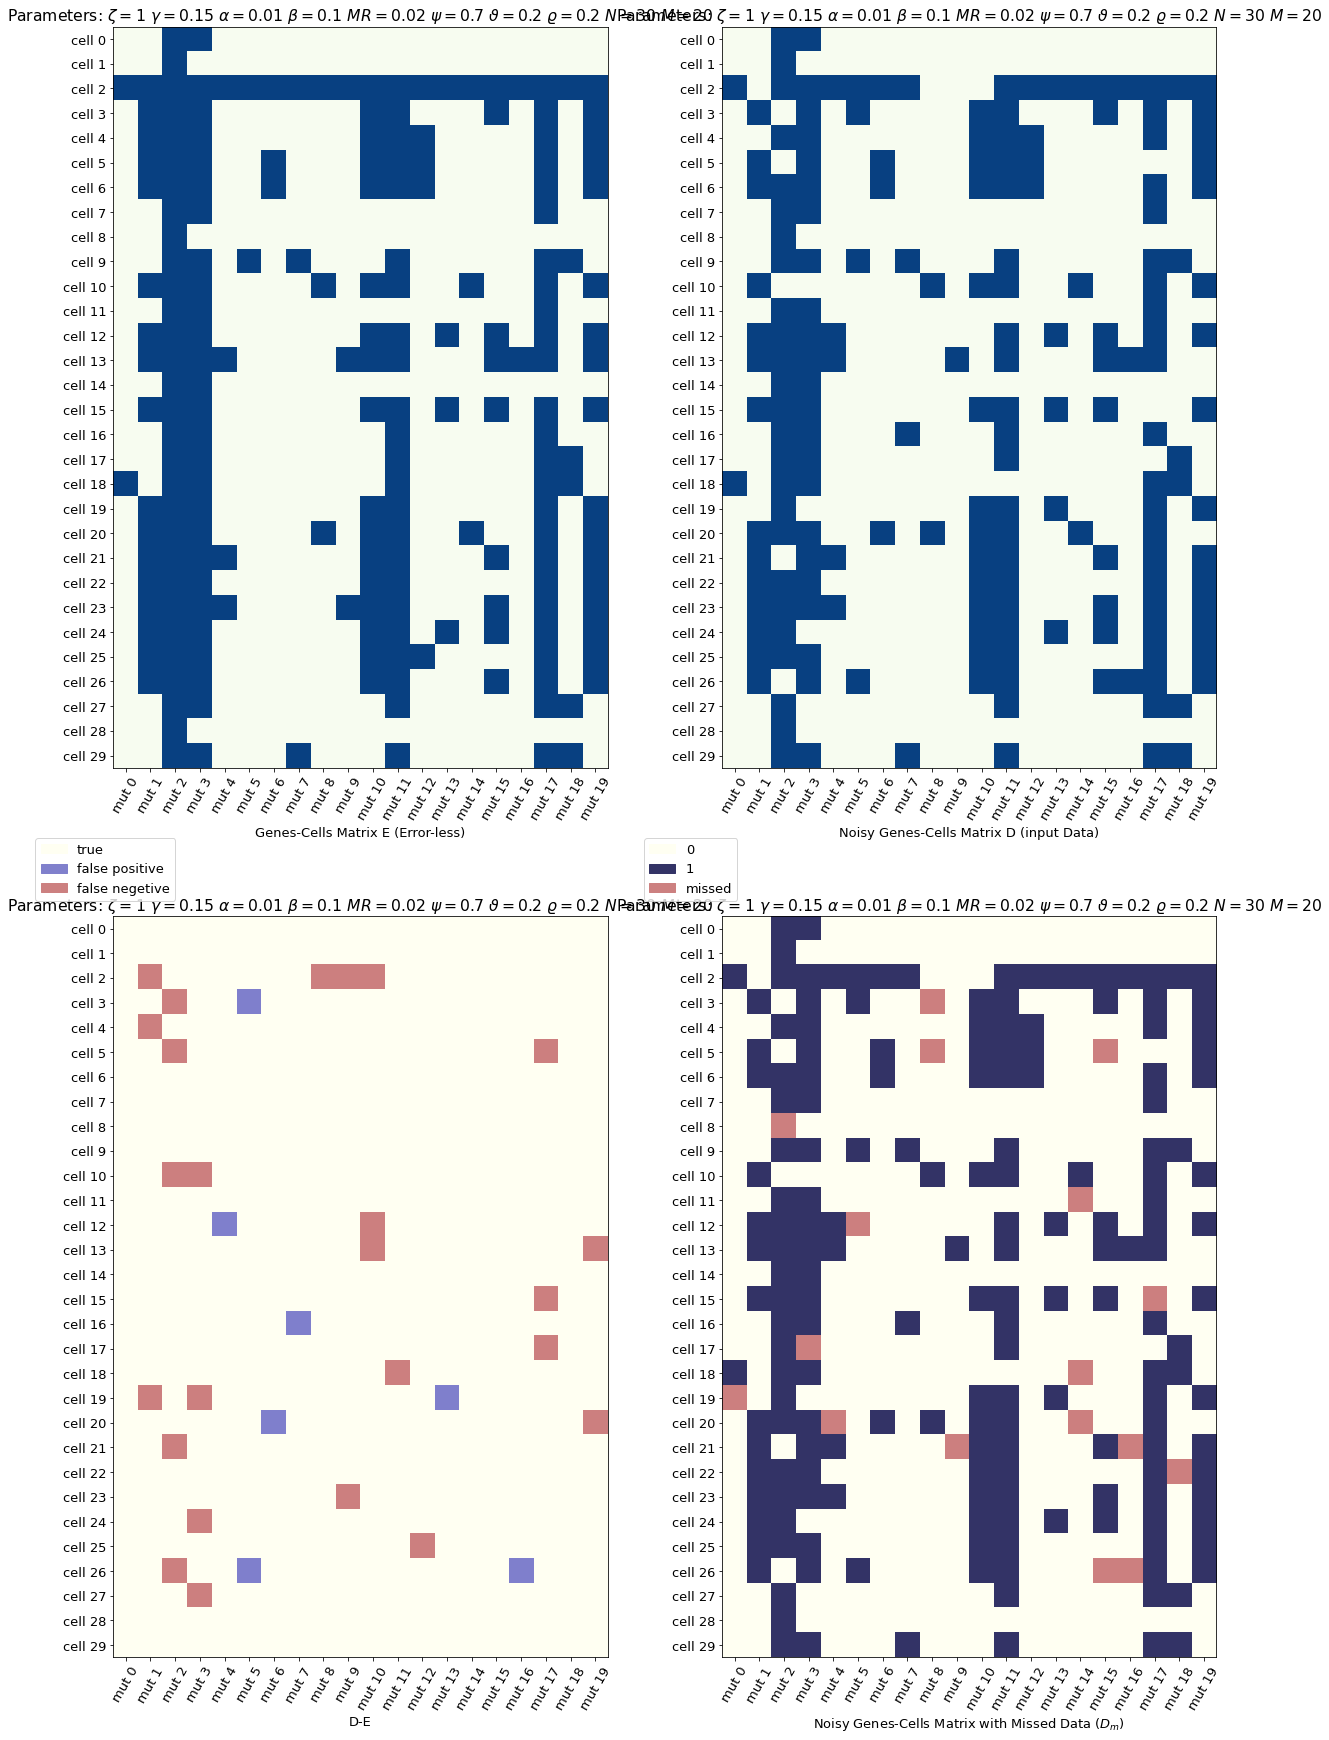

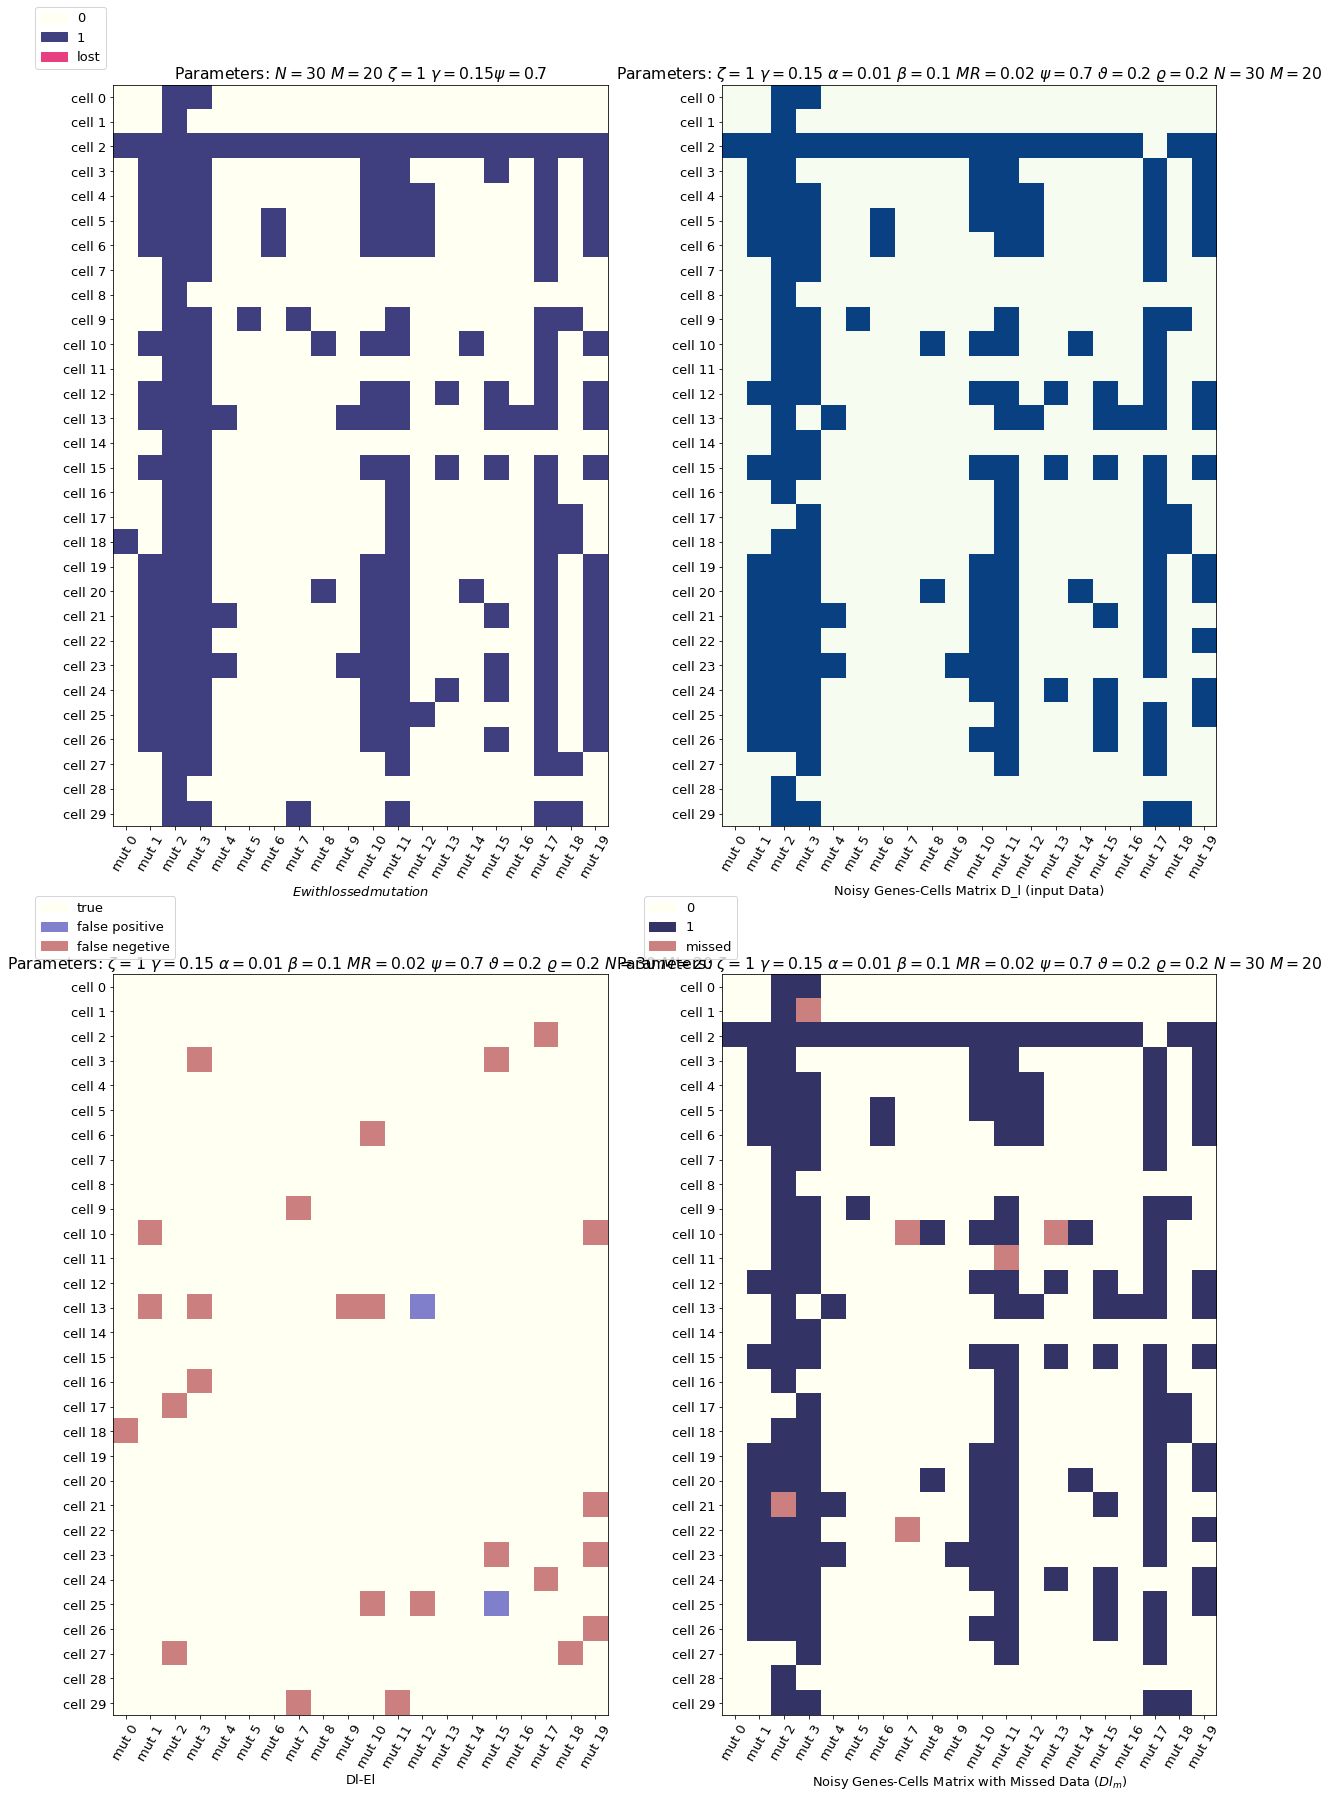

In [33]:
tree_obj.plot_all_mat()

Ground-truth tree with attached samples


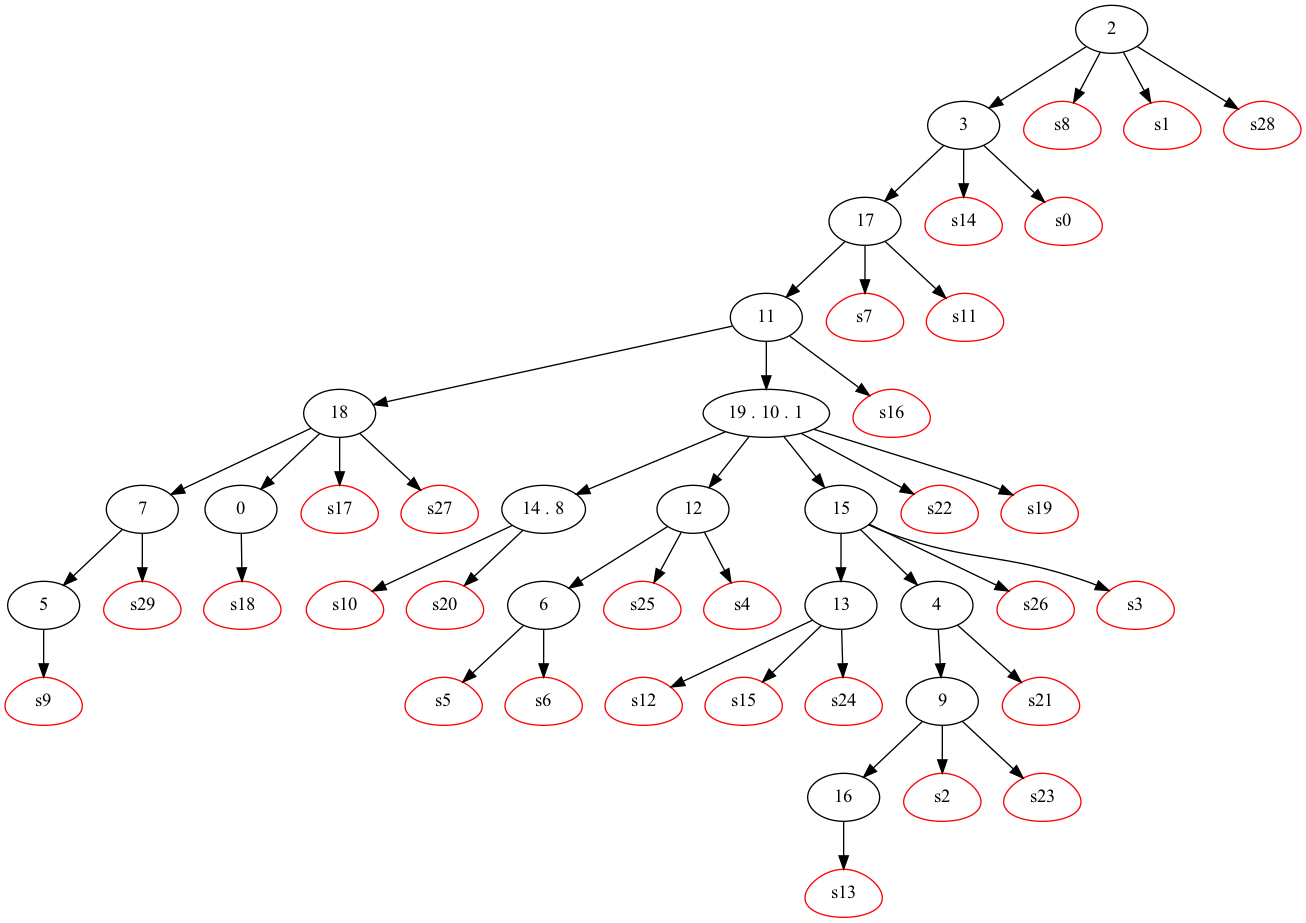

In [35]:
tree_obj.plot_tree_full('../tmp/', title="Ground-truth tree with attached samples")

In [36]:
E = tree_obj.get_E()

In [37]:
T = tree_obj.get_T()

params = tree_obj.get_params()

# the loss probablity of a mutation in T
psi = 0.7
# a parameter respect to distanse
vartheta = 0.2
# the probablity of rejecting lossable genes respect to decreased copy number
varrho = 0.2

cnp_length = 5
gen_cnp_idx = np.random.randint(0, cnp_length, params['M'])

initial_cnp = np.random.randint(2, 5, cnp_length)

In [38]:
def gen_new_cnp(cnp, gen_cnp_idx):
    new_cnp = []
    lossable_genes = []
    for i, cn in enumerate(cnp):
        rnd = np.random.rand()
        if rnd < 0.1:
            new_cnp.append(max(0, cn-1))
            lossable_genes = np.where(gen_cnp_idx == i)[0].tolist()
        elif rnd > 0.85:
            new_cnp.append(min(8, cn+1))
        else:
            new_cnp.append(cn)
    return new_cnp, lossable_genes

In [39]:
root = [n for n,d in T.in_degree() if d==0][0]
cnp_dict = {
    'nodes': {
        str(root): initial_cnp
    },
    'cells': {}
}
lossable_genes_all = {}
for node in nx.traversal.bfs_tree(T, root):
    if node == root: continue
    node_str = str(node)
    for parent in T.predecessors(node):
        break
    parent_cnp = cnp_dict['nodes'][str(parent)]
    if 'cell' in node_str:
        cnp_dict['cells'][node_str] = parent_cnp
    else:
        new_cnp, lossable_genes = gen_new_cnp(parent_cnp, gen_cnp_idx)
        cnp_dict['nodes'][node_str] = new_cnp
        if lossable_genes and np.random.rand() > varrho:
            valid_lossable_genes = []
            dist = 0
            for parent in nx.algorithms.shortest_path(T.to_undirected(), node, root):
                if parent == node: continue
                dist += 1
                if '.' in str(parent):
                    parents = [int(p) for p in parent.split(' . ')]
                    for parent in parents:
                        if parent in lossable_genes:
                            valid_lossable_genes.append((parent, dist))
                else:
                    if parent in lossable_genes:
                        valid_lossable_genes.append((parent, dist))
            
            loss_point = node_str
            for valid_lossable_gen, dist in valid_lossable_genes:
                if str(valid_lossable_gen) in lossable_genes_all.keys():
                    lossable_genes_all[str(valid_lossable_gen)].append({'loss_point': loss_point, 'distance': dist})
                else:
                    lossable_genes_all[str(valid_lossable_gen)] = [{'loss_point': loss_point, 'distance': dist}]

In [40]:
t = json.dumps(lossable_genes_all, indent=2)
print(t)

{
  "3": [
    {
      "loss_point": "11",
      "distance": 2
    }
  ],
  "19": [
    {
      "loss_point": "14 . 8",
      "distance": 1
    },
    {
      "loss_point": "6",
      "distance": 2
    }
  ],
  "10": [
    {
      "loss_point": "14 . 8",
      "distance": 1
    },
    {
      "loss_point": "6",
      "distance": 2
    }
  ],
  "17": [
    {
      "loss_point": "12",
      "distance": 3
    },
    {
      "loss_point": "0",
      "distance": 3
    }
  ]
}


In [41]:
lossed_genes = []
for lossable_gen, values in lossable_genes_all.items():
    if np.random.rand() > psi:
        distances = [v['distance'] for v in values]
        chooseable_points = [v['loss_point'] for v in values]
        choosed_idx = np.random.randint(0, len(distances))
        choosed_distance = distances[choosed_idx]
        choosed_loss_point = chooseable_points[choosed_idx]
        
        lossed_genes.append({
            "gene": str(lossable_gen),
            "loss_point": choosed_loss_point
        })
lossed_genes

[{'gene': '3', 'loss_point': '11'}, {'gene': '17', 'loss_point': '0'}]

In [42]:
CP = np.zeros([params['N'], cnp_length])
for cell, cnp in cnp_dict['cells'].items():
    cell_idx = int(cell.split(' ')[-1])
    for j, cn in enumerate(cnp):
        CP[cell_idx, j] = cn

In [43]:
CP

array([[2., 3., 4., 3., 4.],
       [2., 3., 4., 3., 4.],
       [5., 3., 6., 4., 3.],
       [3., 3., 5., 4., 3.],
       [2., 2., 5., 3., 3.],
       [2., 1., 6., 3., 2.],
       [2., 1., 6., 3., 2.],
       [2., 3., 4., 3., 3.],
       [2., 3., 4., 3., 4.],
       [2., 3., 3., 4., 2.],
       [2., 3., 4., 4., 2.],
       [2., 3., 4., 3., 3.],
       [3., 3., 4., 4., 3.],
       [5., 3., 6., 5., 3.],
       [2., 3., 4., 3., 4.],
       [3., 3., 4., 4., 3.],
       [2., 3., 3., 3., 3.],
       [2., 3., 3., 3., 2.],
       [3., 2., 3., 3., 3.],
       [2., 3., 4., 3., 3.],
       [2., 3., 4., 4., 2.],
       [4., 3., 6., 4., 3.],
       [2., 3., 4., 3., 3.],
       [5., 3., 6., 4., 3.],
       [3., 3., 4., 4., 3.],
       [2., 2., 5., 3., 3.],
       [3., 3., 5., 4., 3.],
       [2., 3., 3., 3., 2.],
       [2., 3., 4., 3., 4.],
       [2., 3., 3., 3., 2.]])

In [44]:
E_l = E.copy()
        
for lossed_gene in lossed_genes:
    gene = lossed_gene["gene"]
    loss_point = lossed_gene["loss_point"]

    try:
        sT = dfs_tree(T, int(loss_point))
    except:
        sT = dfs_tree(T, loss_point)
    cells = [n for n in sT.nodes() if sT.out_degree(n)==0 and sT.in_degree(n)==1]
    for cell in cells:
        cell_idx = int(cell.split(" ")[-1])
        E_l[cell_idx, int(gene)] = 0
        print(f"cell: {cell_idx}, N:{N}, M:{M}, E:{E.shape})")

cell: 10, N:30, M:20, E:(30, 20))
cell: 20, N:30, M:20, E:(30, 20))
cell: 12, N:30, M:20, E:(30, 20))
cell: 15, N:30, M:20, E:(30, 20))
cell: 24, N:30, M:20, E:(30, 20))
cell: 13, N:30, M:20, E:(30, 20))
cell: 2, N:30, M:20, E:(30, 20))
cell: 23, N:30, M:20, E:(30, 20))
cell: 21, N:30, M:20, E:(30, 20))
cell: 26, N:30, M:20, E:(30, 20))
cell: 3, N:30, M:20, E:(30, 20))
cell: 5, N:30, M:20, E:(30, 20))
cell: 6, N:30, M:20, E:(30, 20))
cell: 25, N:30, M:20, E:(30, 20))
cell: 4, N:30, M:20, E:(30, 20))
cell: 22, N:30, M:20, E:(30, 20))
cell: 19, N:30, M:20, E:(30, 20))
cell: 9, N:30, M:20, E:(30, 20))
cell: 29, N:30, M:20, E:(30, 20))
cell: 18, N:30, M:20, E:(30, 20))
cell: 17, N:30, M:20, E:(30, 20))
cell: 27, N:30, M:20, E:(30, 20))
cell: 16, N:30, M:20, E:(30, 20))
cell: 18, N:30, M:20, E:(30, 20))
